In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
matplotlib.rcParams['axes.titlesize'] = 18

Before reading on, you may want to look at the pyspark script used to create this data. Essentially, I grouped the rates for individuals (as opposed to families) by State, age and metal rating, averaged them, and then calculated the percentage change in rates for from year to year.

Here's what it looks like.

In [3]:
change1617 = pd.read_csv('output/changes-1617.csv')
change1617.head()

,StateCode,Age,MetalLevel,avg_IndividualRate_2016,std_IndividualRate_2016,avg_IndividualRate_2017,std_IndividualRate_2017,percentChange
0,GA,60,Silver,866.498681,178.155824,892.291950,148.378491,2.976723
1,IL,64,Silver,833.602069,104.434663,997.416599,146.555705,19.651406
2,IN,24,Silver,277.524333,49.809960,284.862259,60.199285,2.644066
3,MS,62,Bronze,620.842931,91.674673,806.359000,201.441269,29.881321
4,NM,30,Gold,277.348409,40.037537,334.872963,54.818002,20.740899


Let's quickly plot some histograms of the rate changes by metal level -- ignoring age or state for now.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1169f0a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116ba00f0>]], dtype=object)

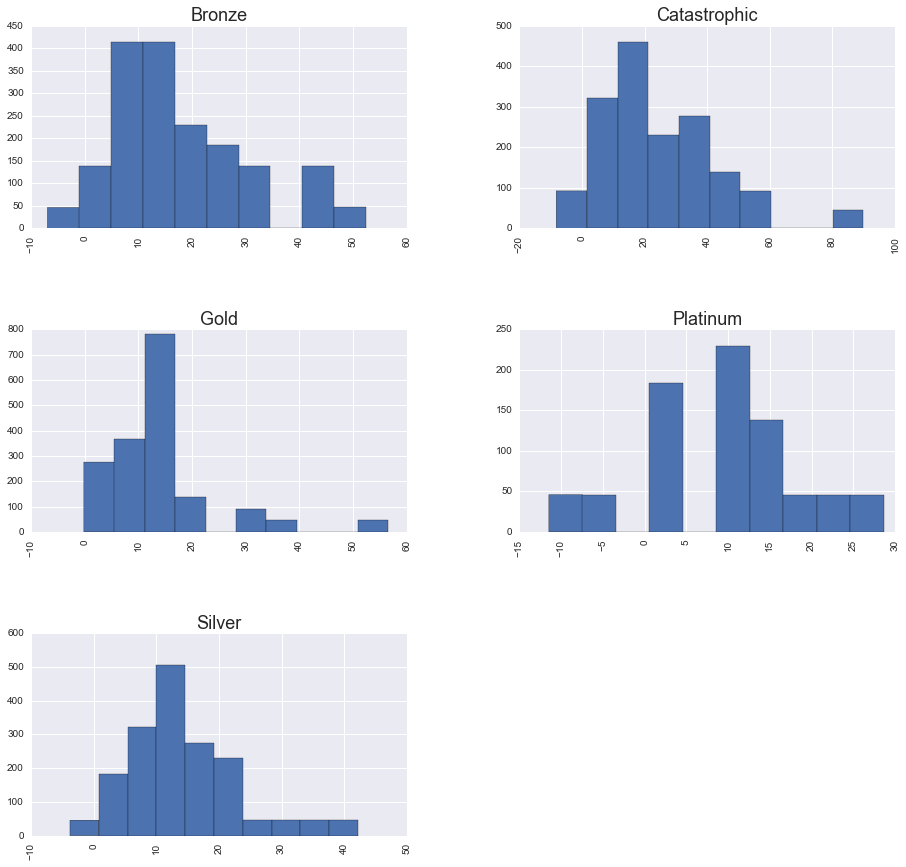

In [7]:
change1617.hist(column='percentChange', by='MetalLevel', figsize=(15, 15))

It looks like the distribution for gold plans is more concentrated than the others. Also, some the rates for some catastrophic plans went way up.

Now let's see plot the rate changes for each age -- still ignoring state for now.

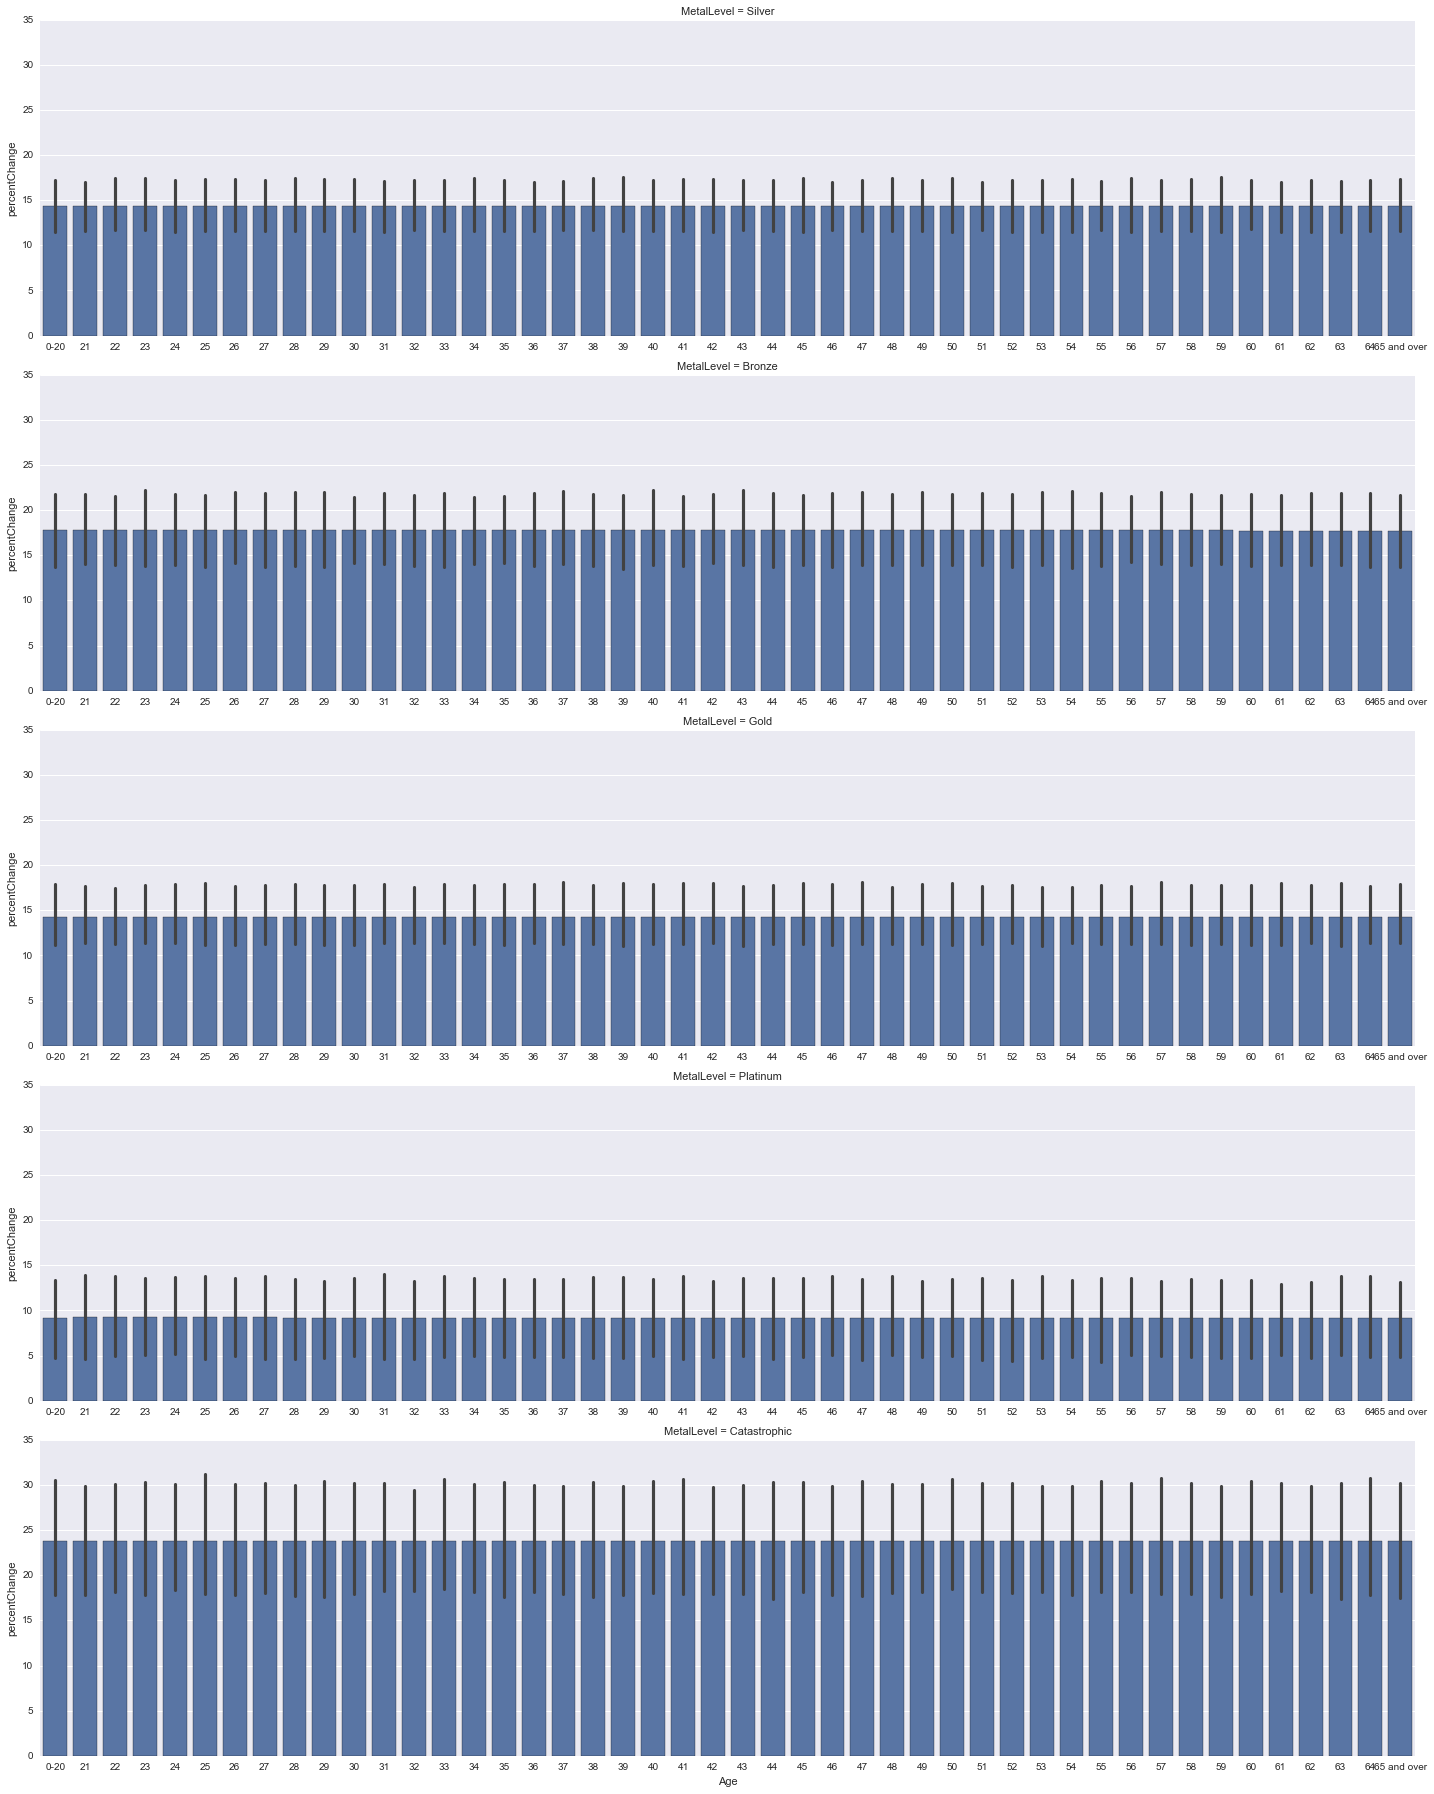

In [8]:
sortedAges = np.sort(change1617.Age.unique())
g = sns.FacetGrid(data=change1617, row='MetalLevel',  size=5, aspect=4, sharex=False)
g.map(sns.barplot, 'Age', 'percentChange', order=list(sortedAges))

Those graphs look so flat it almost seems like a mistake. Age doesn't seem to be associated with rate change for any of the metal levels.

Now plot the changes by state, disregarding age this time.

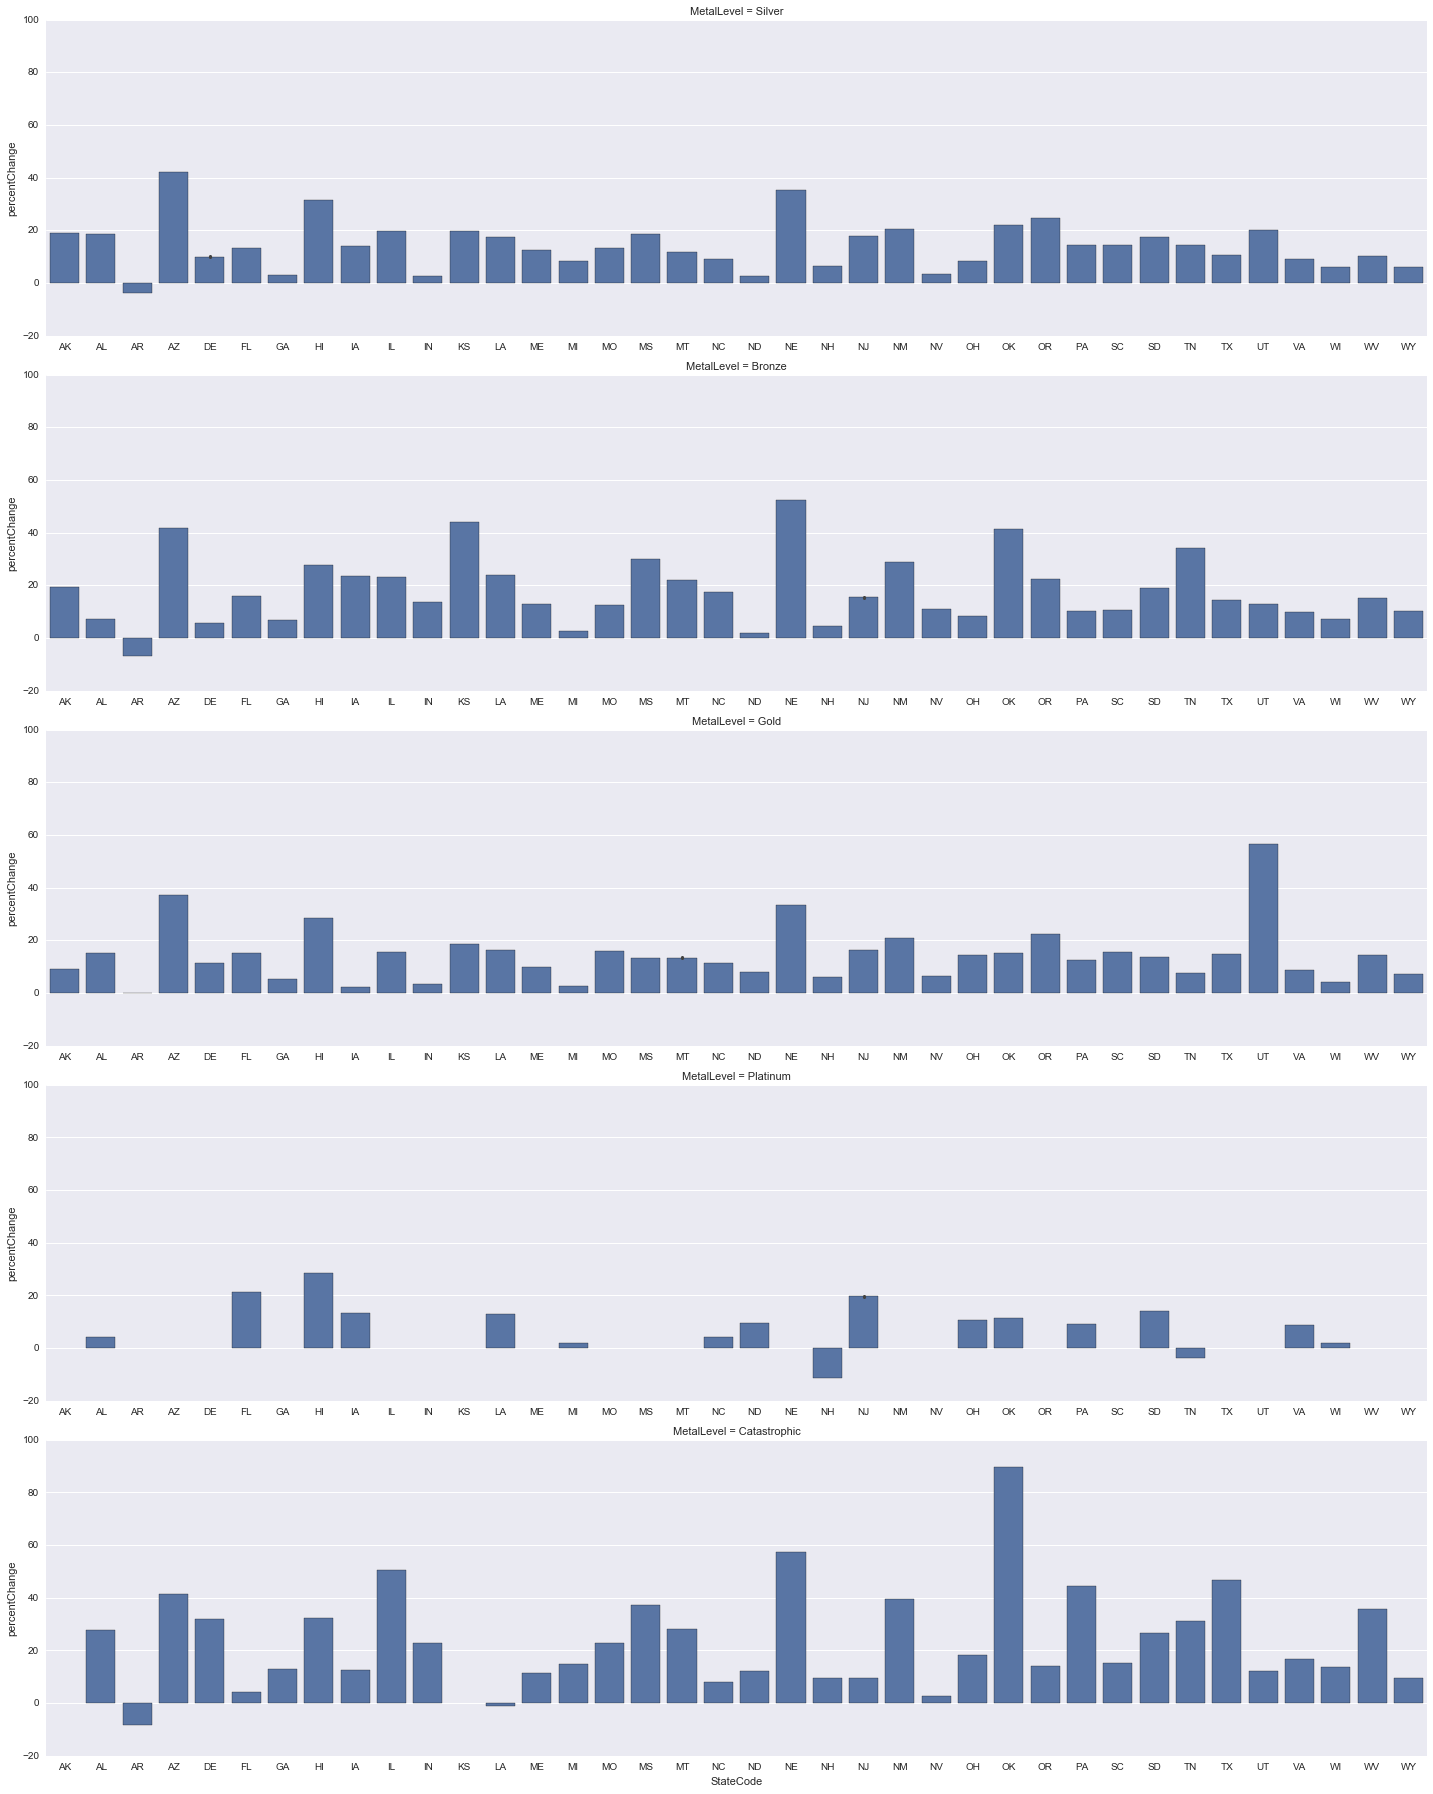

In [9]:
states = np.sort(change1617.StateCode.unique())
g = sns.FacetGrid(data=change1617, row='MetalLevel',  size=5, aspect=4, sharex=False)
g.map(sns.barplot, 'StateCode', 'percentChange', order=list(states))

Nearly every state experienced rate increases in each of the metal levels.

It's hard to compare rate changes within a state using those graphs, so below we plot the changes for all the metal levels on one graph. It's hard to see any pattern. The dots for some states are close together vertically, while others are more spread out.

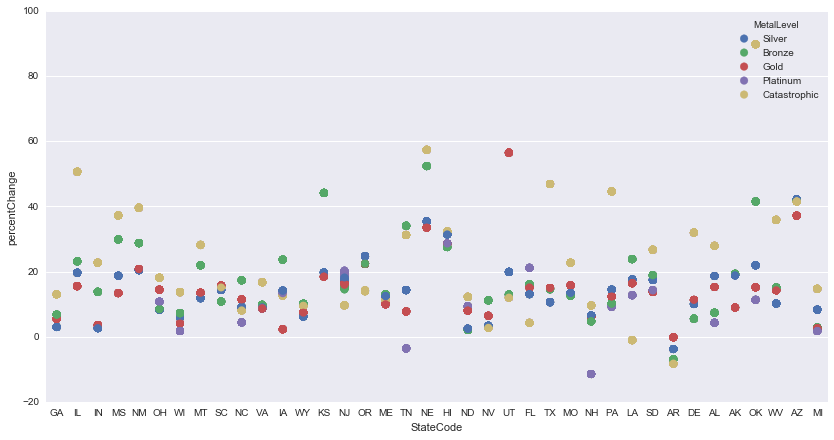

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.stripplot(data=change1617, x='StateCode', y='percentChange', hue='MetalLevel', size=8)

Now we'll incorporate metal level, state and age. As we saw above, once you take metal level and state into account, age doesn't provide much more information.

Lastly, let's make some maps. We'll use the function below to plot the rate changes by state for the gold, silver, bronze and catastrophic levels. Note that states in black are states we don't have data for.

In [17]:
import json
import folium
from folium.colormap import linear

us_states =  r'us-states.json'

geo_json_data = json.load(open(us_states))

fips = pd.read_csv('fips-codes.csv', header=None)
states = pd.DataFrame({'StateCode':pd.Series(fips[0].rename(columns={0:'StateCode'}).unique())})

def makeStateMap(df, dataCol):
    m = folium.Map(location=[43, -100], zoom_start=4)
    
    dataDict = df[df[dataCol].notnull()].set_index('StateCode')[dataCol]
    
    colormap = linear.OrRd.scale(
        df.percentChange.min(),
        df.percentChange.max())
    
    #we need to all the states in our dataset, or folium will throw an error. So we add the states that are missing
    statesToAppend =  pd.Series(index=[state for state in states.StateCode if state not in dataDict.index.values])
    
    #determine the colors for each state -- note we use black for 
    #states that were originally missing from our dataset 
    dataDict = dataDict.append(statesToAppend).fillna(-9999)
    color_dict = {key: colormap(dataDict[key]) if dataDict[key] != -9999 else '#000' for key in dataDict.keys()}
    
    folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': color_dict[feature['id']],
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.9,
    }
).add_to(m)
    
    colormap.caption = 'Percentage Change'
    colormap.add_to(m)
    return m

We'll keep the maps pretty basic. We'll just plot the average change in rate for each state for each year.

In [39]:
df = change1617[change1617.MetalLevel == "Gold"].groupby('StateCode').percentChange.mean().reset_index()
m = makeStateMap(df, 'percentChange')
m.save('change_1617_gold_plans.html')
m

In [38]:
df = change1617[change1617.MetalLevel == "Silver"].groupby('StateCode').percentChange.mean().reset_index()
m = makeStateMap(df, 'percentChange')
m.save('change_1617_silver_plans.html')
m

In [37]:
df = change1617[change1617.MetalLevel == "Bronze"].groupby('StateCode').percentChange.mean().reset_index()
m = makeStateMap(df, 'percentChange')
m.save('change_1617_bronze_plans.html')
m

In [36]:
df = change1617[change1617.MetalLevel == "Catastrophic"].groupby('StateCode').percentChange.mean().reset_index()
m = makeStateMap(df, 'percentChange')
m.save('change_1617_catastrophic_plans.html')
m

### Summary

* Rates increased in nearly every state for every metal level from 2016 to 2017.
* Catastropic plans experienced the highest increases, with bronze second.
* Changes for a given metal level and state are very similar across all age groups.
* The maps failed to reveal any geographic pattern in the rate changes.
